In [ ]:
# by Medvedeva NA
# medvedeva.n.box@yandex.ru
# OD-3. Принятие решения по результатам A/Б-теста/ Unit 54 / DARP-1014

# ``Запуск Акции. A/B-тест посадочной страницы. Маркетинг. ``
маркер лучшего варианта - количество покупок*

    - user_id, идентификатор клиента, зашедшего на сайт
    - date, дата события
    - group, группа теста
    - purchase, совершил клиент покупку или нет
    - price, стоимость единичной покупки

## ``1. Первичный анализ датасета``
  - приведение столбцов к корректным типам данных
  - проверка пересечения аудитории в группах (убираем дубли, не более 5%)
  - проверка корректности распределения участников теста
  - проверка различия в группах
  - соотношение групп по количеству : пользователей, покупок, выручки.
  - расчет конверсии, среднего чека
  - (визуализация) периоды по группам
  - (визуализация) суммы покупок по группам
  - первичные выводы

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
# from google.colab import drive # подкл. гугл диска к колабу
# drive.mount('/content/gdrive')

ab_df = pd.read_csv('sda_3.0_54_ab_data.csv', sep=',')   # 294 478, 100% визитов
ab_df.user_id.nunique()                                  # 290 584, 100% пользователей

# убрать лишние столбцы
ab_df = ab_df.drop(['Unnamed: 0'], axis=1)

# date в формат datetime, тест: 2/01/2021 - 24/01/2021
ab_df['date'] = pd.to_datetime(ab_df['date'], format='%Y-%m-%d')

# Маркировка групп стоимостей
def route_mark(row):
    if row==10000:
        return 'SPB'
    elif row==100000:
        return 'Thailand'
    elif row==60000:
        return 'Turkiye'
    elif row==150000:
        return 'Kamchatka'
    elif row==200000:
        return 'Maldives'
    else:
        'error'
ab_df['countries'] = ab_df['price'].apply(route_mark)


# Разделение групп А/В
gr_a = ab_df.query('group == "A"').reset_index().sort_values(by='index')  # A-визиты 147 202, A-пользователи 146 195
gr_b = ab_df.query('group == "B"').reset_index().sort_values(by='index')  # В-визиты 147 276, В-пользователи 146 284

display(ab_df)
ab_df.info()

,user_id,date,group,purchase,price,countries
0,851104,2021-01-21,A,0,0,None
1,804228,2021-01-12,A,0,0,None
2,661590,2021-01-11,B,0,0,None
3,853541,2021-01-08,B,0,0,None
4,864975,2021-01-21,A,1,150000,Kamchatka
...,...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0,None
294474,945152,2021-01-12,A,0,0,None
294475,734608,2021-01-22,A,0,0,None
294476,697314,2021-01-15,A,0,0,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    294478 non-null  int64         
 1   date       294478 non-null  datetime64[ns]
 2   group      294478 non-null  object        
 3   purchase   294478 non-null  int64         
 4   price      294478 non-null  int64         
 5   countries  35237 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.5+ MB


In [ ]:
# А/А-тест.  Проверка корректности распределения аудитории.
# A-визиты 145 307, А-пользователи 144 300
# В-визиты 145 381, В-пользователи 144 389

'''_________________________________________________________________________________________
1. Проверить, что данные по аудитории собираются корректно
   В течении всего времени один пользователь должен видеть только одну версию продукта, те попасть в разные группы теста.
   Данные об измеряемой метрике, должны измеряться для каждой из групп теста корректно. '''
# пересечение А ∩ В = 1895 пользователей (1%)
# 1% пользователей попали в обе группы
dupl_users = gr_a.merge(gr_b, on='user_id', how='inner')
d1 = round(1895/290584*100)
# Так невозможно определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей.

ids_dataset = set(ab_df.user_id)                                      # set {290 584} - 100% пользователей
ids_dupl_set = set(dupl_users.user_id)                                # set {1895}
ids_dif = ids_dataset.difference(ids_dupl_set)                        # 290 584-1895 = 288 689 : 100% пользователей (-1895 пользователей)
ids_dif_df = pd.DataFrame(data = ids_dif, columns = ['user_id'])      # set в df
ab_data_dif = ab_df.merge(ids_dif_df, on='user_id', how='inner')      # 290 688 : 100% визитов (-1895 пользователей)

# Разделение на группы. За вычетом 5% пользователей {1895}
group_A = ab_data_dif.query('group == "A"').reset_index().sort_values(by='index')   # A-визиты 145 307, А-пользователи 144 300
group_B = ab_data_dif.query('group == "B"').reset_index().sort_values(by='index')   # В-визиты 145 381, В-пользователи 144 389



'''_________________________________________________________________________________________
2. Проверить на корректность механизма распределения аудитории
   Если аудитория должна делиться 50/50, но в результате есть расхождение >1%, то механизм распределения работает некорректно.'''
a1 = round(145307/290688*100) # 50% визиты гр.А
b1 = round(145381/290688*100) # 50% визиты гр.B
a2 = round(144300/288689*100) # 50% пользователи гр.А
b2 = round(144389/288689*100) # 50% пользователи гр.А
# Аудитория разделилась 50/50, нет расхождений > 1% механизм распределения работает некорректно



'''_________________________________________________________________________________________
3. Проверить группы на аномалии
   Целевые метрики, не должны отличаться в обеих группах более чем на 1%.
   стоит проверить группы на выбросы/аномалии. В результате такого теста должно быть отсутствие различия в группах.'''
#  Целевы метрики данного проекта: конверсия(CR,%) и средний чек(AOV) по каждой группе
# g1 = ab_data_dif.groupby(['group'])['user_id'].count().reset_index()
# g2 = ab_data_dif.groupby(['group'])[['purchase', 'price']].sum().reset_index()

ab = ab_data_dif.groupby(['group']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).reset_index()
ab['AOV'] = round(ab['price']/ab['purchase'],2)
ab['CR_perc'] = round(ab['purchase']/ab['user_id']*100,2)
display(ab)


# (относительная) конверсия в группе 'B' меньше на 1.16%. Несмотря на то что в группе 'B' было больше посетителей
# За счёт меньшей конверсии в группе 'B' было меньше покупок,
# однако выручка группы 'B' больше выручки группы 'A' на 115 230 000 единиц (7.5%)
# Большая выручка в группе 'B' складывается за счёт того, что средний чек группы 'B' выше среднего чека группы 'A'




,group,user_id,purchase,price,AOV,CR_perc
0,A,145307,17487,1417780000,81076.23,12.03
1,B,145381,17290,1533010000,88664.55,11.89


'Группа A'

,countries,count_purch,price
2,SPB,5182,10000.0
4,Turkiye,5271,60000.0
3,Thailand,1832,100000.0
0,Kamchatka,3478,150000.0
1,Maldives,1724,200000.0


'Группа В'

,countries,count_purch,price
2,SPB,5201,10000.0
4,Turkiye,1730,60000.0
3,Thailand,5227,100000.0
0,Kamchatka,3438,150000.0
1,Maldives,1694,200000.0


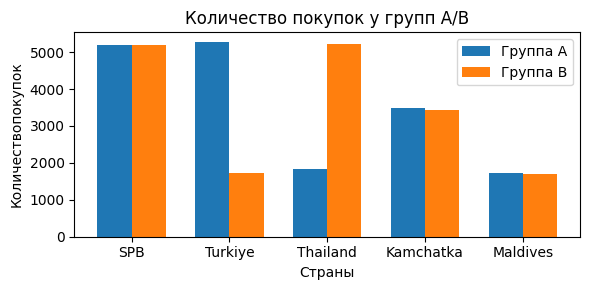

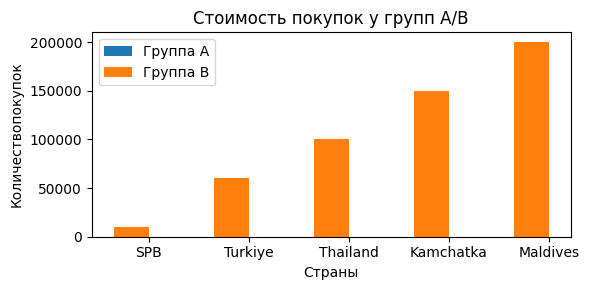

In [ ]:
# Визуализация распределения выручки по странам для групп А и В
prices_A = group_A.groupby(['countries'])['price'].agg(['count','mean']).reset_index().sort_values(by='mean')
prices_A.columns = ['countries','count_purch','price']
display('Группа A', prices_A)

prices_B = group_B.groupby(['countries'])['price'].agg(['count','mean']).reset_index().sort_values(by='mean')
prices_B.columns = ['countries','count_purch','price']
display('Группа В', prices_B)


import matplotlib.pyplot as plt
import numpy as np

countries = list(prices_A.countries)
x = np.arange(len(prices_A.countries))


# Диаграмма распределения количества покупок у групп А/В
fig, ax = plt.subplots(figsize=(6, 3))
rects1 = ax.bar(x - 0.35/2, prices_A.count_purch, 0.35, label='Группа А')
rects2 = ax.bar(x + 0.35/2, prices_B.count_purch, 0.35, label='Группа В')

ax.set_xlabel('Страны')
ax.set_ylabel('Количествопокупок')
ax.set_title('Количество покупок у групп А/В')
ax.set_xticks(x)
ax.set_xticklabels(countries)
ax.legend()

fig.tight_layout()
plt.show()


# Диаграмма распределения стоимости покупок у групп А/В
fig, ax = plt.subplots(figsize=(6, 3))
rects1 = ax.bar(x - 0.35/2, prices_A.price, 0.35, label='Группа А')
rects2 = ax.bar(x - 0.35/2, prices_B.price, 0.35, label='Группа В')

ax.set_xlabel('Страны')
ax.set_ylabel('Количествопокупок')
ax.set_title('Стоимость покупок у групп А/В')
ax.set_xticks(x)
ax.set_xticklabels(countries)
ax.legend()

fig.tight_layout()
plt.show()
# Участники группы A чаще покупают туры за 60 000Р (Турция), но реже покупают туры за 100 000Р (Таиланд)
# В остальном покупательская способность обеих групп похожа



## ``2. Рассчет кумулятивных метрик``
   - график конверсии в группах по дням
   - график среднего чека в группах по дням
   - график кумулятивных метрик по конверсии и по среднему чеку
   - выводы

In [ ]:
# Сводная таблица количества пользователей и ц.действий для групп А/В по каждому дню
ab_piv = ab_data_dif.groupby(['date','group']).agg({'user_id':'count','purchase':'sum','price':'sum'}).reset_index()

# CR - количество целевых действий / количество пользователей
ab_piv['CR'] = ab_piv['purchase'] / ab_piv['user_id']
ab_piv['AOV'] = ab_piv['price'] / ab_piv['purchase']


# Разбивка на группы
a_piv = ab_piv[ab_piv['group'] == 'A']
b_piv = ab_piv[ab_piv['group'] == 'B']

In [ ]:
# Функция которая для каждой X-даты timestamp отфильтрует строки таблицы,
# где значения X-даты <= X-дате.
def cummulative_table(data):      # data << название переменной датафейма
    df_cumm = []                  # пустой список
    for i in data['date'].values: #  цикл по каждому значению X-даты
        out = data[data['date'] <= i].groupby('group')\
               .agg({'date':'max', 'user_id':'sum', 'purchase':'sum', 'price':'sum'})
        df_cumm.append(out)                 # out в df_cumm
    return pd.concat(df_cumm).reset_index() # Объединяем списки и возвращаем результат


# Кумулятивные таблицы групп А и В :
# за каждый день отображаются данные накопленным итогом.
cumm_a = cummulative_table(a_piv)
cumm_b = cummulative_table(b_piv)

# CR в кумулятивных таблицах
cumm_a['CR'] = cumm_a['purchase'] / cumm_a['user_id']
cumm_b['CR'] = cumm_b['purchase'] / cumm_b['user_id']

# AOV в кумулятивных таблицах
cumm_a['AOV'] = round(cumm_a['price'] / cumm_a['purchase'],2)
cumm_b['AOV'] = round(cumm_b['price'] / cumm_b['purchase'],2)

display(cumm_a.tail())
display(cumm_b.tail())

,group,date,user_id,purchase,price,CR,AOV
18,A,2021-01-20,121506,14561,1179590000,0.119838,81010.23
19,A,2021-01-21,128256,15412,1249890000,0.120166,81098.49
20,A,2021-01-22,134843,16200,1313580000,0.120140,81085.19
21,A,2021-01-23,141541,17043,1384530000,0.120410,81237.46
22,A,2021-01-24,145307,17487,1417780000,0.120345,81076.23


,group,date,user_id,purchase,price,CR,AOV
18,B,2021-01-20,121857,14496,1286900000,0.118959,88776.21
19,B,2021-01-21,128412,15256,1356770000,0.118805,88933.53
20,B,2021-01-22,135071,16043,1425430000,0.118775,88850.59
21,B,2021-01-23,141704,16848,1494360000,0.118896,88696.58
22,B,2021-01-24,145381,17290,1533010000,0.118929,88664.55


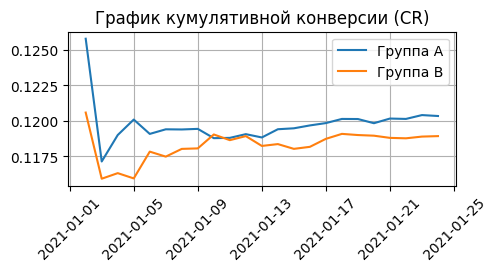

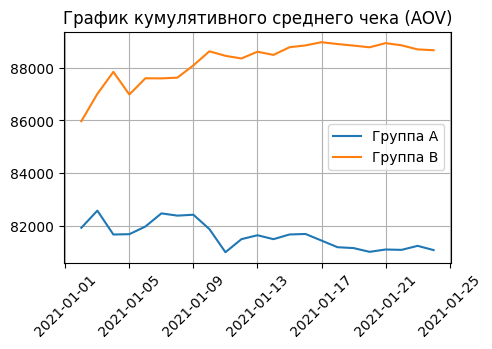

'\n\n Изначально конверсия группы_B была ниже конверсии группы_А. Она показывала стабильный рост.\n\n ~ 10янв.2021 конверсия группы_B стала выше конверсии группы_А. Зафиксировалась на этом уровне (с колебаниями).\n\n Конверсия группы_А начала постепенно расти.\n\n В результате конверсия группы_А стабильно выше группы_B.\n\n Cредний чек(AOV) группы_B` > среднего чека группы_А '

In [ ]:
# График кумулятивной конверсии по дням (обе группы)
import matplotlib.pyplot as plt

plt.figure(figsize=(5,2))
plt.plot(cumm_a['date'], cumm_a['CR'], label='Группа A')
plt.plot(cumm_b['date'], cumm_b['CR'], label='Группа B')
plt.title('График кумулятивной конверсии (СR)')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.show()


# График кумулятивного Среднего Чека по дням (обе группы)
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(cumm_a['date'], cumm_a['AOV'], label='Группа A')
plt.plot(cumm_b['date'], cumm_b['AOV'], label='Группа B')
plt.title('График кумулятивного среднего чека (AOV)')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.show()

# Вывод:
'''
\n Изначально конверсия группы_B была ниже конверсии группы_А. Она показывала стабильный рост.
\n ~ 10янв.2021 конверсия группы_B стала выше конверсии группы_А. Зафиксировалась на этом уровне (с колебаниями).
\n Конверсия группы_А начала постепенно расти.
\n В результате конверсия группы_А стабильно выше группы_B.
\n Cредний чек(AOV) группы_B` > среднего чека группы_А '''

## ``3. Статистическая проверка гипотез``
   - о равенстве конверсии
   - о равенстве выручки
   - о равенстве средних чеков по дням
   - выводы

0.239


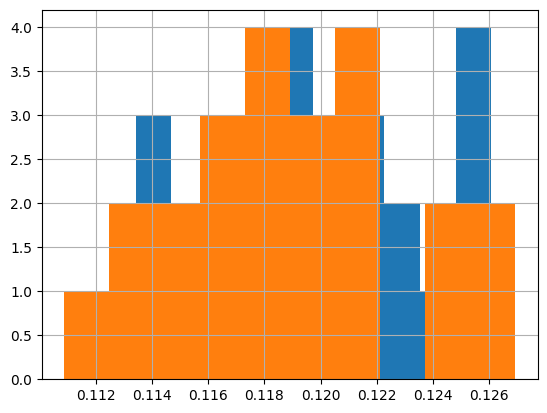

In [ ]:
# 1. ГИПОТЕЗА о равенстве конверсии
#    Проверка распределения показателей конверсии в группах

# выборки CR
df_a = ab_piv[ab_piv['group'] == 'A']['CR']
df_b = ab_piv[ab_piv['group'] == 'B']['CR']

# гистограмма с нормальным  распределением
df_a.hist()
df_b.hist()

# Нулевая и альтернативная гипотезы :
# H0: CR(гр.A) = CR(гр.B),
# H1: CR(гр.A) != CR(гр.B)

import numpy as np
import math as mth
import random
import pandas as pd
from scipy import stats as st

#  Z - ТЕСТ
alpha = 0.05

n1 = group_A['user_id'].count()  # посетители сайта А
n2 = group_B['user_id'].count()  # посетители сайта В
x1 = group_A[(group_A['purchase'] == 1)]['user_id'].count()  # конверсии А
x2 = group_B[(group_B['purchase'] == 1)]['user_id'].count()  # конверсии В
p1 = x1/n1
p2 = x2/n2
p = (x1+x2) / (n1+n2)
diff = p1-p2 # разницa в пропорциях

# Z-оценка = 1.64
z = diff / np.sqrt(p * (1 - p) * (1/n1 + 1/n2))

# Зададим нормальное стандартное распределение со средним = 0, и стандартным отклонением = 1
distr = st.norm(0, 1)

# Расчет p-value:
p_val = (1 - distr.cdf(abs(z))) * 2

print(round(p_val,3))
# p-value = 0.239 > alpha = 0.05
# Отвергаем нулевую гипотезу, так как между долями есть значимая разница.
# P-value больше принятого уровня значимости(0,05), те статистически значимая разница между конверсиями отсутствует.


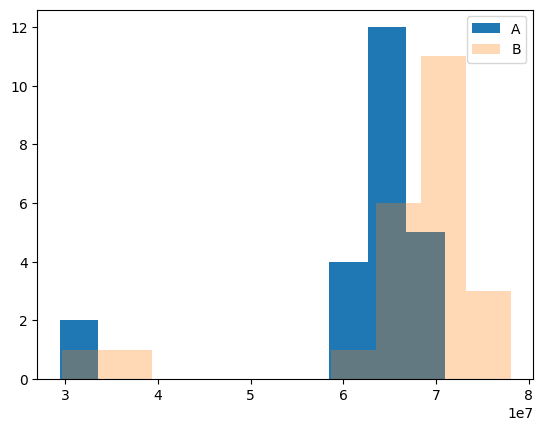

Статистически значимой разницы нет. Отвергнуть нулевую гипотезу не получилось.


0.00028893174193897724

In [ ]:
# 2. ГИПОТЕЗА о равенстве выручки
#    Проверка различия в стоимости заказов между группами

revenue_A = ab_piv[(ab_piv['group'] == 'A') & (ab_piv['purchase'] > 0)]['price']
revenue_B = ab_piv[(ab_piv['group'] == 'B') & (ab_piv['purchase'] > 0)]['price']

# гистограмма не с нормальным распределением
plt.hist(revenue_A, label='A')
plt.hist(revenue_B, label='B', alpha=0.3)
plt.legend()
plt.show()

# Нулевая и альтернативная гипотезы :
# H0: AOV_A = AOV_B
# H1: AOV_A != AOV_B

# Тест Манна-Уитни : Проверка различия в стоимости заказов между группами
alpha = 0.05
results = st.mannwhitneyu(revenue_A, revenue_B)
p = results.pvalue

if  p < alpha :
    print('Статистически значимой разницы нет. Отвергнуть нулевую гипотезу не получилось.')
else :
    print('Статистически значимая разница есть. Отвергаем нулевую гипотезу.')

# p-value < alpha, отвергаем нулевую гипотезу: стоимости заказов не равны.
# Вариант сайта_B приносит значимо больше выручки, чем вариант сайта_A

p-value = 2.2523589349617907e-12 < alpha = 0,05
Отвергаем нулевую гипотезу о равенстве средних (p_value < alpha) - Cредние баллы не равны.


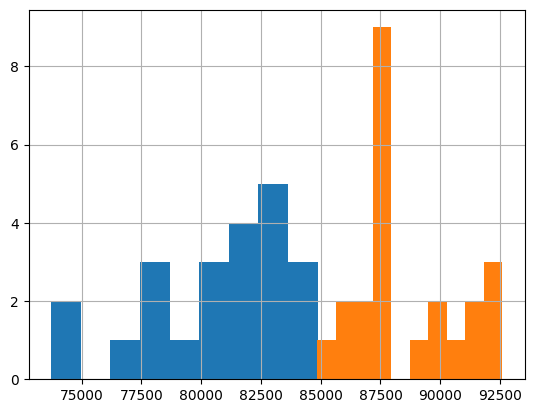

In [ ]:
# 3. ГИПОТЕЗА о равенстве средних чеков(AOV) по дням
#    Проверка различия средних чеков по дням

# Гистограмма с нормальным распределением
ab_piv[ab_piv['group'] == 'A']['AOV'].hist()
ab_piv[ab_piv['group'] == 'B']['AOV'].hist()

# Средние чеки по дням
sample_a = ab_piv[ab_piv['group'] == 'A']['AOV'] # выборка 1
sample_b = ab_piv[ab_piv['group'] == 'B']['AOV'] # выборка 2

# T - Тест : проверка равенства средних 2х ген. совокупностей
from scipy import stats as st
import numpy as np

alpha = 0.05
p_value = st.ttest_ind(sample_a, sample_b, equal_var = True)
p = p_value.pvalue
print(f'p-value = {p} < alpha = 0,05') # 2.2523589349617907e-12


def t_test_results(results,  alpha=0.05):
  if (results < alpha):
     print("Отвергаем нулевую гипотезу о равенстве средних (p_value < alpha) - Cредние баллы не равны.")
  else:
     print("Не отвергаем нулевую гипотезу - Средние баллы обеих групп равны")
t_test_results(p)



## Вывод:
- СR группы_B ниже, но статистической значимости в конверсии не достигнуто, те, считать конверсии разными оснований нет.

- Зато AOV группы_B значительно выше AOV группы_A. Статистическая значимость достигнута.

- Вариант сайта_B приносит значимо больше выручки, чем вариант сайта_A.

- Рекомендуем признать, что вариант_B лучше, чем вариант_A!

# ```ОБЗОР МЕТОДОВ ПРОВЕРКИ ГИПОТЕЗ```

## **T - Тест** : проверка разницы средних значений 2х совокупностей
- при нормальном распределенияя
- наблюдений > 30

In [ ]:
# Т - ТЕСТ
print('ГИПОТЕЗА 1, о  равенстве средних 2х ген. совокупностей')
# H0 : ср.бал М = ср.б. Ж
# H1 : ср.бал М != ср.б. Ж


# ПРИМЕР
'''Предположим, в некоторой школе решили разделить мальчиков и девочек на две одинаковые группы
и проверить, что средний балл по предметам у мальчиков равен среднему баллу у девочек. '''

# Создадим генеральную совокупность: оценки [от 1 до 5], n = 1000 наблюдений.
import numpy as np
import random
import pandas as pd
from scipy import stats as st

df = []
for i in range(0,1000):
   r = random.randint(1, 5)
   df.append(r)

df = np.array(df)      # df выборка, ген.совокупность
mean_df = df.mean()    # настоящее среднее ген.совокупности


# Разделим выборку на равные по численности группы А/В
df_a = df[0:500]
df_b = df[500:1000]

# Из каждой части возьмём равные выборки по сто оценок в каждой:
sample_a = np.random.choice(df_a, size=100)  # выборка 1
sample_b = np.random.choice(df_b, size=100)  # выборка 2

# Расчет p-value
alpha = 0.05
p_value = st.ttest_ind(sample_a, sample_b, equal_var = True)
p = round(p_value.pvalue,2) # print('p-value = ',p)

# Сравнение
def t_test_results(p,  alpha=0.05):
  if (p < alpha):
     print(f'p = {p} < alpha = 0.05, Отвергаем нулевую гипотезы - Cредние баллы не равны')
  else:
     print(f'p = {p} > alpha = 0.05, Не отвергаем нулевую гипотезу - Средние баллы обеих групп равны')
t_test_results(p)

print(f'в группах есть отличие среднего балла, с вероятностью {p*100}%')
print('это отличие получено случайно если p < alpha')
print('____________________________________________________________________')


# T - ТЕСТ
print('ГИПОТЕЗА 2, о равенстве среднего ген.совокупности конкретному значению')
print(f'выборочное среднее = {sample_a.mean()}, сравниваем со средним ген.совокупности = {mean_df}')
# H0 : Выборочное среднее = среднее ген.совокупности
# H1 : Выборочное среднее < среднее ген.совокупности

t_test = st.ttest_1samp(sample_a, df.mean()) # на вход: значения выборки и значение, с которым проводят сравнение
p = round(t_test.pvalue/2, 4)                # тк тест односторонний, то полученное значение p-value делится на два

# Сравнение
if (p < alpha) and (sample_a.mean() < df.mean()):
   print(f'p = {p} < alpha = 0.05, Отвергаем нулевую гипотезу')
else:
   print(f'p = {p} > alpha = 0.05, Не отвергаем нулевую гипотезу')


# Если гипотеза двусторонняя (two-sided) : sample_a.mean() > df.mean(), тогда
# p-value/2
# sample_a.mean() > df.mean())

# Если  гипотеза односторонняя (one-sided) : sample_a.mean() = df.mean(), без учёта больше оно или меньше, тогда
# делить p-value/2 нет необходимости.
# Второе условие также не требуется.


ГИПОТЕЗА 1, о  равенстве средних 2х ген. совокупностей
p = 0.21 > alpha = 0.05, Не отвергаем нулевую гипотезу - Средние баллы обеих групп равны
в группах есть отличие среднего балла, с вероятностью 21.0%
это отличие получено случайно если p < alpha
____________________________________________________________________
ГИПОТЕЗА 2, о равенстве среднего ген.совокупности конкретному значению
выборочное среднее = 3.0, сравниваем со средним ген.совокупности = 2.978
p = 0.4383 > alpha = 0.05, Не отвергаем нулевую гипотезу


## **Z - Тест** : проверки разницы долей
- при достаточном количестве наблюдений

In [ ]:
# Z-Тест
'''
 сравнение показателя конверсии сайта для группы A и B
 стандартное нормальное распределение: Z ~ N(0,1)
 cреднее = 0, стандартное отклонение = 1  '''

# ПРИМЕР
'''
В группе А и B — 400 посетителей сайта.
Трафик распределился равномерно — 50/50. В группе А - 64 конверсии, в группе B — 92.
Принятый уровень статистической значимости — 5% '''

# M - средние исследуемых генеральных совокупностей
# H0 : M1 = M2
# H1 : M1 != M2

import numpy as np
import math as mth
import random
import pandas as pd
from scipy import stats as st

alpha = 0.05

n1 = 200    # генеральная совокупность А
n2 = 200    # генеральная совокупность В

X1 = float(64)  # кол-во конверсий А
X2 = float(92)  # кол-во конверсий В

p1 = X1/n1
p2 = X2/n2
p = (X1+X2)/400
diff = p1-p2 # разницa в пропорциях

# расчет Z статистики :
stat_z = diff/ np.sqrt(p * (1 - p) * (1/n1 + 1/n2))

# Зададим нормальное стандартное распределение со средним = 0, и стандартным отклонением = 1
distr = st.norm(0, 1)

# Расчет p-value:
p_val = (1 - distr.cdf(abs(stat_z))) * 2

print(f'p_value = {round(p_val,3)} < alpha = 0.05')
# Отвергаем нулевую гипотезу, так как между долями есть значимая разница.


p_value = 0.004 < alpha = 0.05


## **U-тест** Манна-Уитни: сравнение средних значений
- при распределении, далёком от нормального.
- значения в обеих выборках сортируются по убыванию и ранжируются. Работа с рангами позволяет игнорировать выбросы в выборках.


In [ ]:
# Критерий Шапиро-Уилка
import pandas as pd
import scipy.stats as st

df = pd.read_excel('blogger_likes.xlsx')

# Запишем количество лайков каждого блогера в отдельную переменную:
blogger_1 = df[df['group'] == 'A']['likes']
blogger_2 = df[df['group'] == 'B']['likes']

# гистограммы, распределение далеко от нормального
blogger_1.hist()
blogger_2.hist(alpha=0.4)

# Зададим уровень значимости и применим теста Манна-Уитни:
alpha = 0.05
results = st.mannwhitneyu(blogger_1, blogger_2)
p = round(results.pvalue,3)

if  p < alpha :
  print('Статистически значимой разницы нет. Отвергнуть нулевую гипотезу не получилось.')
else :
    print('Статистически значимая разница есть. Отвергаем нулевую гипотезу.')

# results.pvalue < alpha, похоже, что количество лайков, получаемых в сутки, одинаково.


FileNotFoundError: ignored

## Критерий **Шапиро-Уилка** : проверка нормальности распределения ген.совокупности по имеющейся выборке.


,Year,Profit
0,1821,1645
1,1822,658
2,1823,1926
3,1824,865
4,1825,764


p > alpha, Распределение далеко от нормального. Рекомендуется применять U-Тест


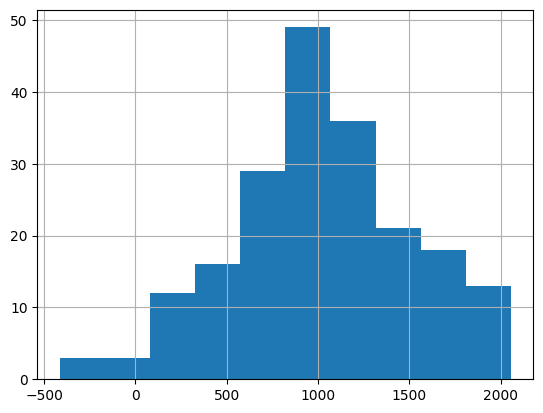

In [ ]:
import pandas as pd
from scipy import stats as st

df = pd.read_csv('sda_3.0_54_shapiro_uilka.csv')

display(df.head())
df['Profit'].hist() # распределение нормальное!

# H0: Распределение нормальное!
# H1: Распределение далеко от нормального

alpha = 0.05
sh = st.shapiro(df['Profit'])
p = round(sh.pvalue,3)

if p < alpha:
   print('p > alpha, Следовательно, нам стоит принять нулевую гипотезу: распределение нормальное')
else:
    print('p > alpha, Распределение далеко от нормального. Рекомендуется применять U-Тест')


## **Z - Тест** : для проверки средних значений
- при известной дисперсии генеральной совокупности